## Maternal Health Risk
#### Algorithm name: Boosting

In [ ]:
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import(
    train_test_split,
    cross_validate,
    cross_val_predict,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import(
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler
)
from sklearn.ensemble import(
    GradientBoostingClassifier
)
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    DetCurveDisplay,
    confusion_matrix
)
from sklearn.inspection import(
    permutation_importance
)
from sklearn.compose import(
    ColumnTransformer
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

### **1. Data loading**
**Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
df_raw = pd.read_csv('data/Maternal_Health Risk_Data_Set.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [3]:
df_raw.sample(10, random_state=2025)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
109,32,140,100,7.9,98.0,78,high risk
185,55,100,65,6.1,98.0,66,low risk
402,35,100,70,7.8,98.0,60,low risk
800,32,120,80,6.8,98.0,70,mid risk
684,32,140,100,6.9,98.0,78,high risk
555,50,130,100,16.0,98.0,75,mid risk
34,21,75,50,6.1,98.0,70,low risk
689,40,160,100,19.0,98.0,77,high risk
172,20,100,90,7.1,98.0,88,low risk
528,15,78,49,7.5,98.0,77,low risk


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
df_baking = df_raw.copy()
df_baking.columns = df_baking.columns.str.lower()
df_baking = df_baking[["age","systolicbp","diastolicbp","bs","bodytemp","heartrate","risklevel"]]
df_baking['risklevel'] = df_baking['risklevel'].astype('category')
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          1014 non-null   int64   
 1   systolicbp   1014 non-null   int64   
 2   diastolicbp  1014 non-null   int64   
 3   bs           1014 non-null   float64 
 4   bodytemp     1014 non-null   float64 
 5   heartrate    1014 non-null   int64   
 6   risklevel    1014 non-null   category
dtypes: category(1), float64(2), int64(4)
memory usage: 48.8 KB


### Explication of variables

* Age: Patient's age
* Systolic bp: The pressure in your arteries when your heart contracts, or beats.
* Diastolic bp: It is the pressure of the blood in the arteries when the heart relaxes between beats.
* bs: Blood glucose levels is in terms of a molar concentration.
* bodytemp: The temperature of the body.
* heartrate: The pulses per second
* RiskLevel: A category of high, mid, or low risk

### **3. Exploratory Data Analysis**
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [41]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
systolicbp,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
diastolicbp,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
bs,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
bodytemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
heartrate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


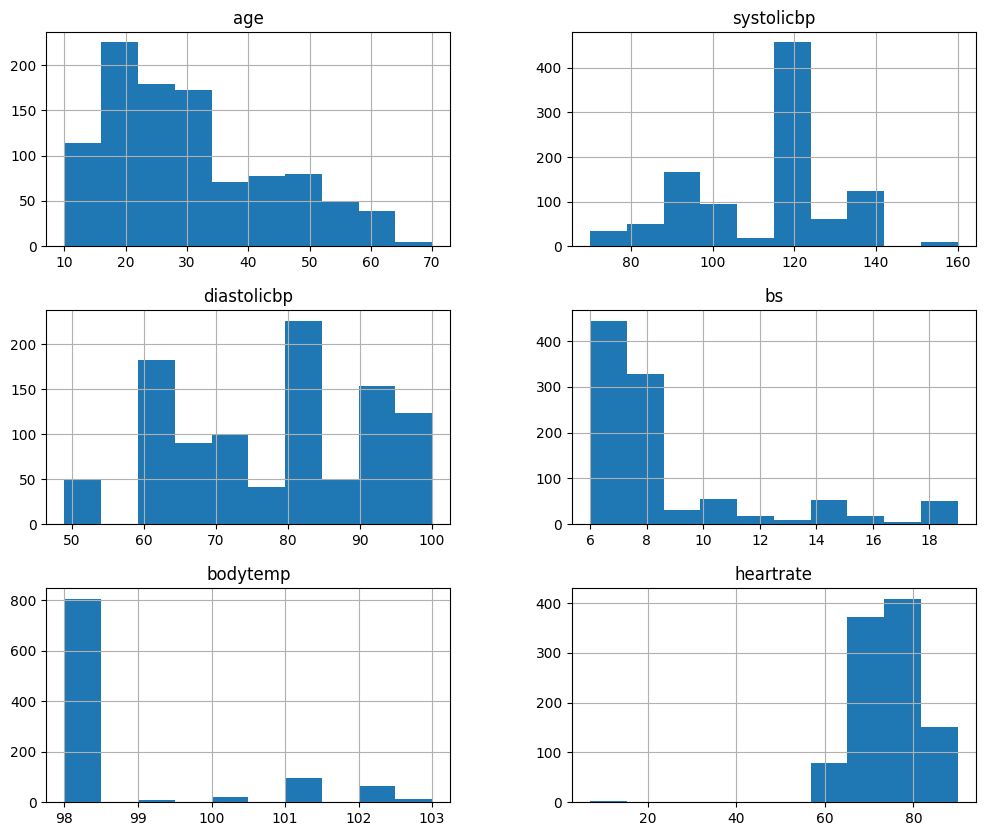

In [5]:
# Distribution of numerical features
df.hist(figsize=(12, 10))
plt.show()

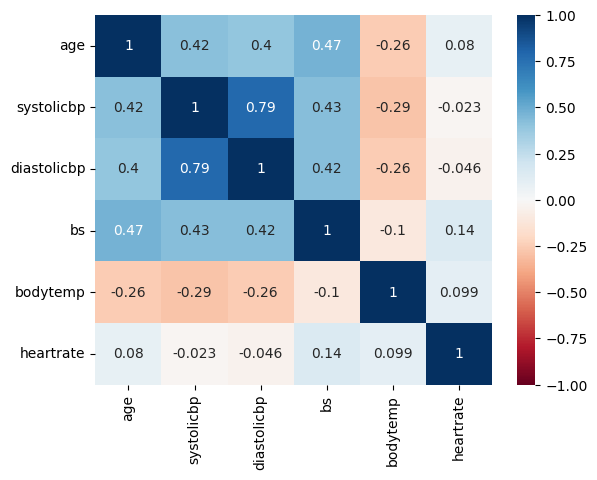

In [6]:
#Heatmap of correlations
sns.heatmap(data=df.select_dtypes('number').corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

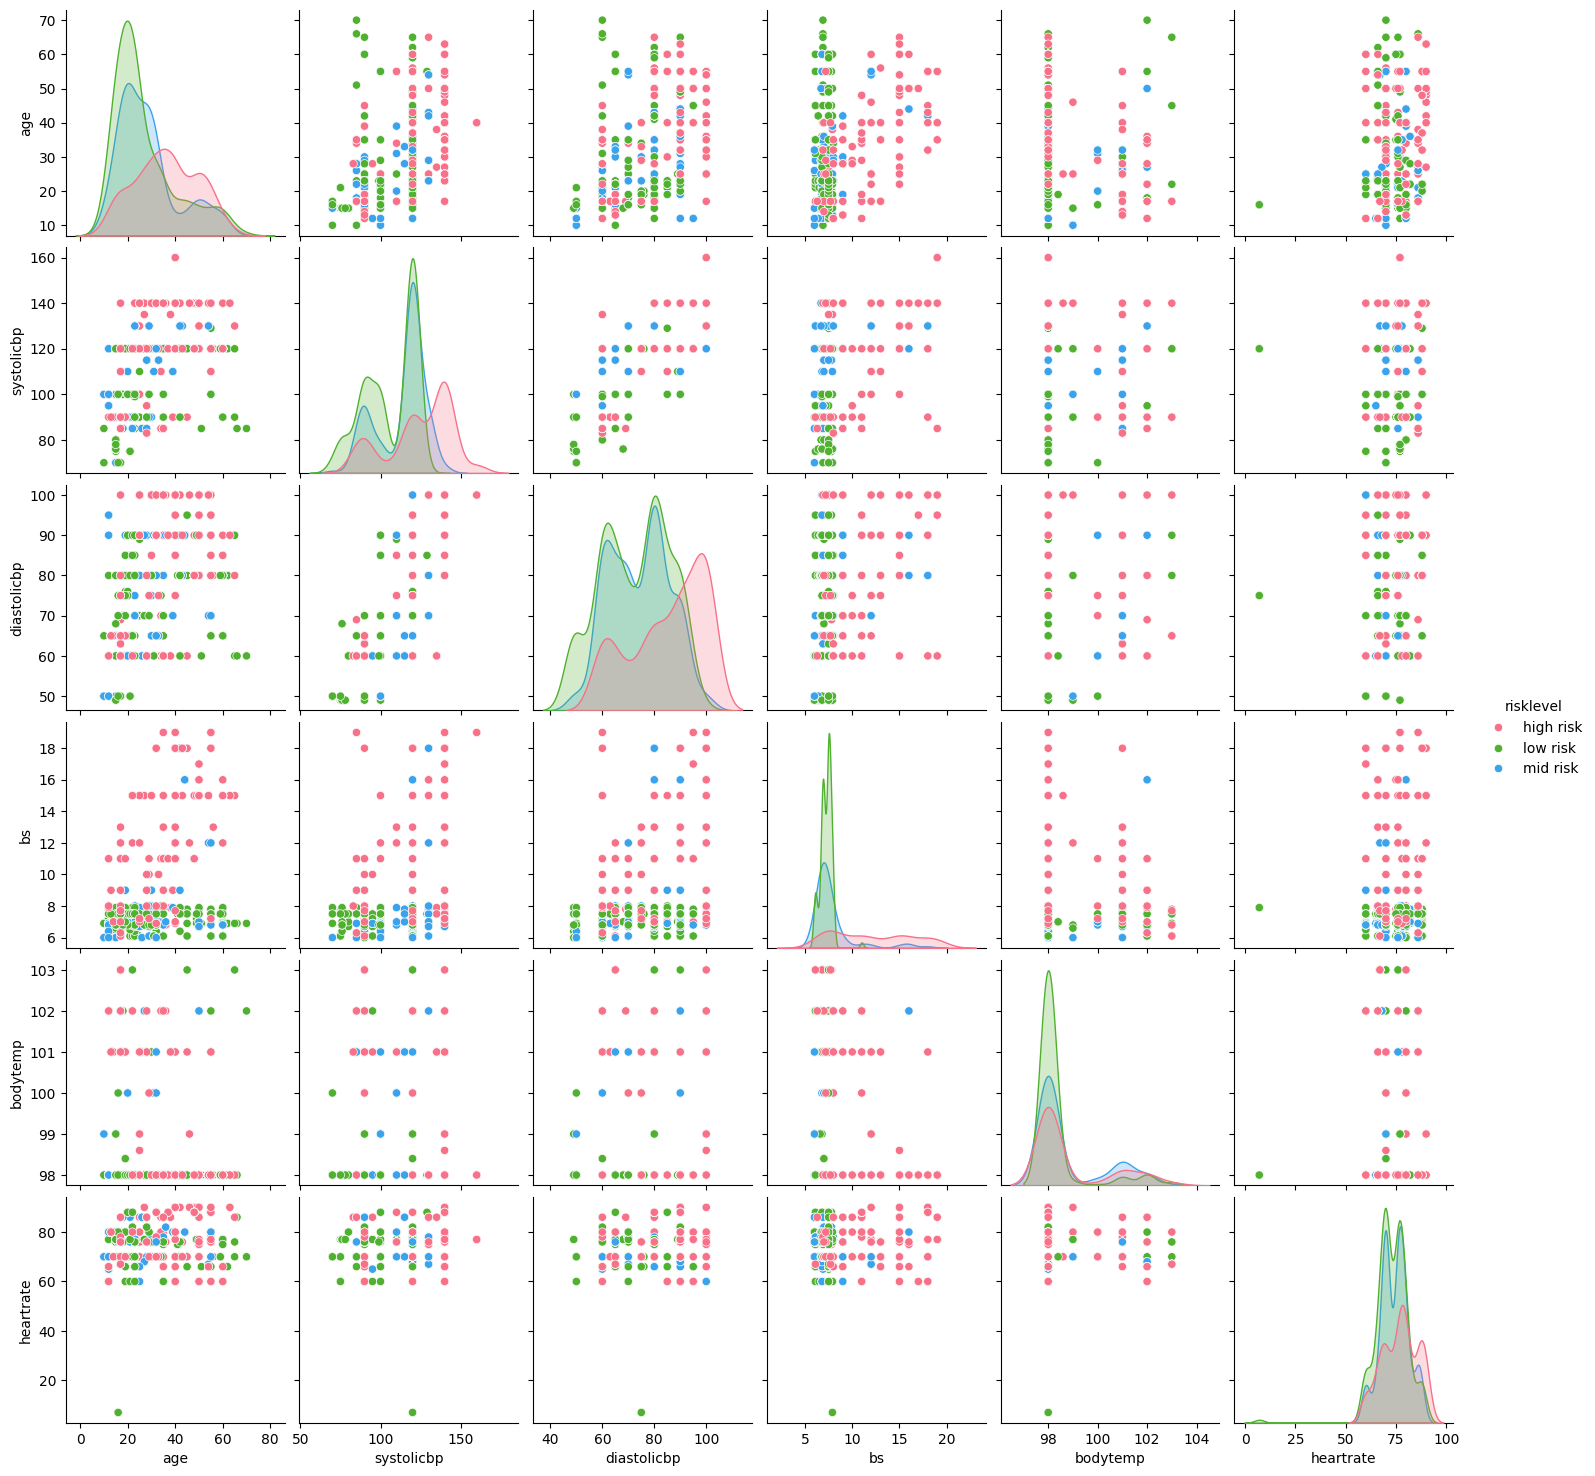

In [7]:
# Pairplot for visualizing feature relationships
sns.pairplot(df, hue="risklevel", palette="husl")
plt.show()

/tmp/ipykernel_13907/3987574735.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="risklevel", data=df, palette="pastel")


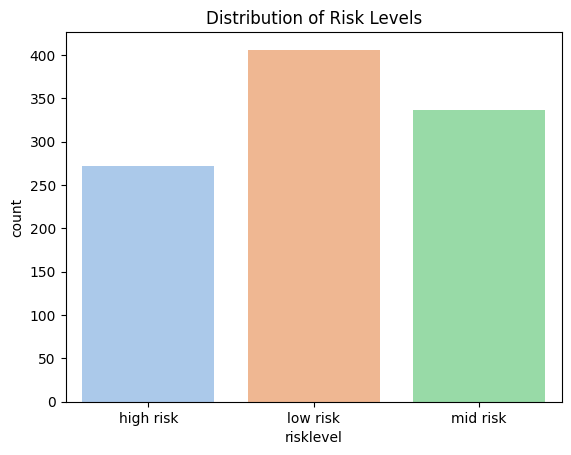

In [8]:
# Countplot of the target variable
sns.countplot(x="risklevel", data=df, palette="pastel")
plt.title("Distribution of Risk Levels")
plt.show()

### 4. Machine learning
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [9]:
# Encode the target variable
label_encoder = LabelEncoder()
df["risklevel"] = label_encoder.fit_transform(df["risklevel"])

# Split dataset into features and target
X = df.drop(columns=["risklevel"])
y = df["risklevel"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, random_state=42)

In [11]:
y_pred_gb = gb_model.predict(X_test)

In [17]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

gb = GradientBoostingClassifier(random_state=2025)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_gb = grid_search.best_estimator_
y_pred_best_gb = best_gb.predict(X_test)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


              precision    recall  f1-score   support

   high risk       0.85      0.87      0.86        47
    low risk       0.81      0.80      0.81        80
    mid risk       0.76      0.76      0.76        76

    accuracy                           0.80       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.80      0.80      0.80       203



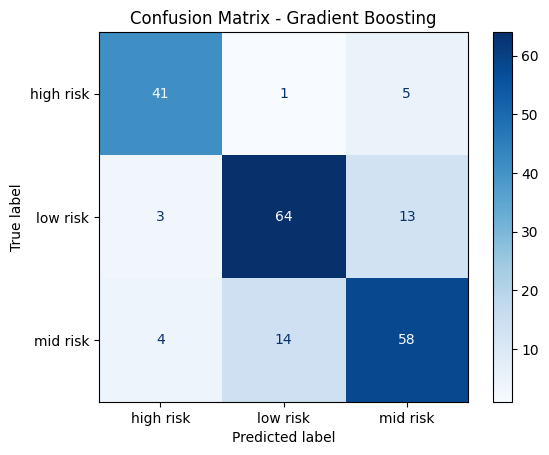

In [15]:
report_gb = classification_report(y_test, y_pred_gb, target_names=label_encoder.classes_)
print(report_gb)
cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()

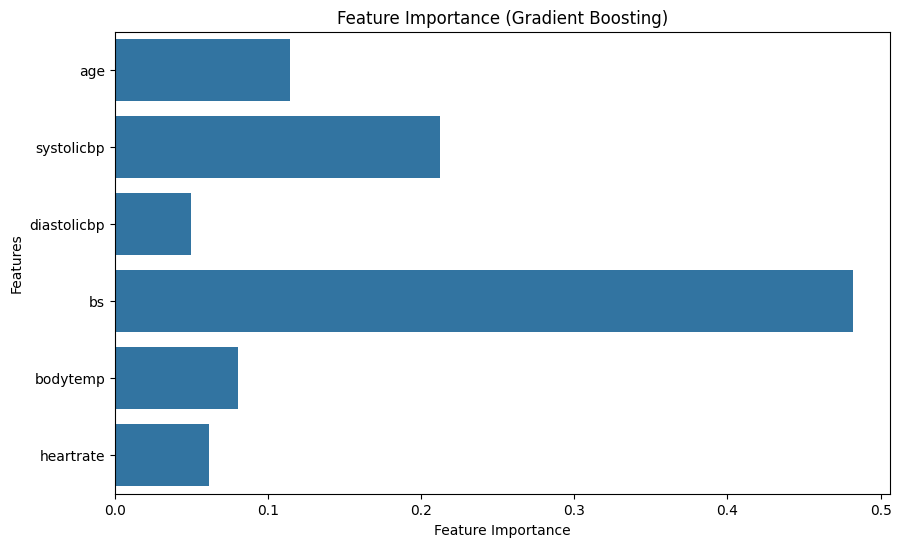

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=gb_model.feature_importances_, y=X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Gradient Boosting)")
plt.show()